In [ ]:
# default_exp modelling

In [ ]:
#export
import math
import scipy as sp
import scipy.optimize
import numpy as np

In [ ]:
#export
_default_sigmoid_p = (1,1,0,0)
def sigmoid(x, sigma, amp, x0, y0):
    """Sigmoid function
    params:
        - x: 1D numpy array at which to evaluate the points
        - sigma: steepness of the sigmoid
        - amp: amplitude of the sigmoid
        - x0: shift in x of the sigmoid
        - y0: shift in y of the sigmoid
    """
    return amp / (1.0 + np.exp(-sigma*(x-x0))) + y0

_default_gaussian_p = (1,1,0,0)
def gaussian(x, sigma, amp, x0, y0):
    """Gaussian function
    params:
        - x: 1D numpy array at which to evaluate the points        
        - sigma: width of the gaussian
        - amp: amplitude of the gaussian
        - x0: shift in x of the gaussian
        - y0: shift in y of the gaussian
    """
    return amp * np.exp(-(x-x0)**2 / (2*sigma**2)) + y0

_default_2Dgaussian_p = (1,1,1,0,0,0,0)
def gaussian_2D(xz, sigma_x, sigma_z, amp, theta, x0, z0, y0):
    """Two dimensional Gaussian function
    params:
        - xz: meshgrid of x and z coordinates at which to evaluate the points
        - sigma_x: width of the gaussian
        - sigma_z: height of the gaussian
        - amp: amplitude of the gaussian
        - theta: angle of the gaussian (in radian)
        - x0: shift in x of the gaussian
        - z0: shift in z of the gaussian
        - y0: shift in y of the gaussian
    """
    (x,z) = xz
    x0, z0 = float(x0), float(z0)
    a =  (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_z**2)
    b = -(np.sin(2*theta)) /(4*sigma_x**2) + (np.sin(2*theta)) /(4*sigma_z**2)
    c =  (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_z**2)
    g = amp * np.exp( -(a*((x-x0)**2) + 2*b*(x-x0)*(z-z0) + c*((z-z0)**2))) + y0
    return g.ravel()

def sum_of_gaussian(t, sigma_1, amp_1, x0_1, 
                       sigma_2, amp_2, x0_2, y0):
    return (gaussian(t, sigma_1, amp_1, x0_1, 0) 
            + gaussian(t, sigma_2, amp_2, x0_2, 0) + y0)

def sum_of_2D_gaussian(xy, sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1,
                           sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0):
    return (gaussian_2D(xz, sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1, 0) 
            + gaussian_2D(xz, sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, 0) + y0)


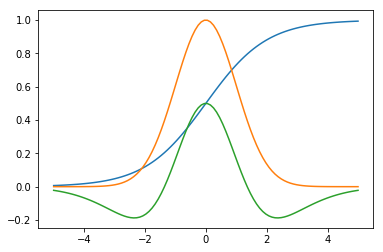

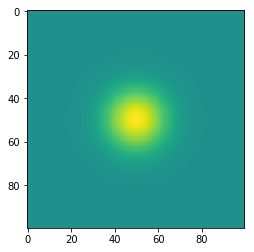

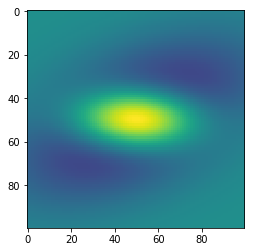

In [ ]:
import matplotlib.pyplot as plt
len_ = 100
x = np.linspace(-5,5,len_)
plt.figure()
plt.plot(x, sigmoid(x,*_default_sigmoid_p))
plt.plot(x, gaussian(x,*_default_gaussian_p))
plt.plot(x, sum_of_gaussian(x, 1,1,0,  2,-.5,0, 0))

xz = np.meshgrid(x,x)
plt.figure()
plt.imshow(gaussian_2D(xz, *_default_2Dgaussian_p).reshape(len_,len_), vmin=-1, vmax=1)
plt.figure()
plt.imshow(sum_of_2D_gaussian(xz, 2,1,2,0,0,0,
                                  2,4,-1,2,0,0, 0).reshape(len_,len_), vmin=-1, vmax=1)


In [ ]:
from nbdev.export import *
notebook2script()